In [2]:
# Time series forecast using Facebook Prophet library
# Dataset: Shipping data between US and China. Company dataset
# Aim: To forecast amount of TEUS to be shipped between the 2 routes
# Note: TEUS means 20feet container equivalent

import numpy as np
import pandas as pd
from datetime import timedelta
from matplotlib import pyplot as plt
from fbprophet import Prophet


In [3]:
# Read CSV and convert column to datetime
dataM = pd.read_csv('US-China-Import-9ans.csv', encoding='latin-1')
dataM['VMONTH'] = pd.to_datetime(dataM['VMONTH'])
dataM.head(2)

,VDATE,VMONTH,VQUARTER,VYEAR,SHIPNAME,VESSEL,CONQTY,TEUS
0,2008-01-01 00:00:00,2008-01-01,2008 Q1,2008,MEDITERRANEAN SHIPPING COMPANY,MSC MARINA,1,2.00
1,2008-01-01 00:00:00,2008-01-01,2008 Q1,2008,GUARANI LINE LTD,EVER DELIGHT,4,5.07


In [3]:
input_var = input("Enter Company Name: ")
dataFull = dataM[dataM.SHIPNAME.str.contains(input_var)]
dataFull.head(2)

Enter Company Name: CMA


,VDATE,VMONTH,VQUARTER,VYEAR,SHIPNAME,VESSEL,CONQTY,TEUS
5,2008-01-02 00:00:00,2008-01-01,2008 Q1,2008,CMA-CGM,CMA CGM PURPLE,523,872.84
27,2008-01-02 00:00:00,2008-01-01,2008 Q1,2008,CMA-CGM,CMA CGM KINGFISH,343,1560.22


In [5]:
# Date range selection
dataZim1 = dataFull[(dataFull['VMONTH']<'2016-07-31')]

In [ ]:
#dataZim1.head(2)

In [6]:
# Calculate Teus monthly
dataZim1 = dataZim1[['VMONTH', 'TEUS']].groupby('VMONTH').agg(np.sum).reset_index().sort_values('VMONTH')
dataZim1.head(2)

,VMONTH,TEUS
0,2008-01-01,61626.91
1,2008-02-01,49898.22


In [7]:
# Prophet library datafram copy and rename column
df2 = dataZim1.copy()
df2['ds'] = df2['VMONTH']
df2['y'] = df2['TEUS']

In [8]:
df2.head(2)

,VMONTH,TEUS,ds,y
0,2008-01-01,61626.91,2008-01-01,61626.91
1,2008-02-01,49898.22,2008-02-01,49898.22


In [9]:
# Input major Holidays in China and US
holidaysChina = pd.DataFrame({
  'holiday': 'new_Year',
  'ds': pd.to_datetime(['2014-01-31','2015-02-19','2016-02-08',
                        '2017-01-28','2018-02-16']),
  'lower_window': 0,
  'upper_window': 3,
})

In [10]:
#Prophet setup using prefered parameters 
pierZim = Prophet(weekly_seasonality=False,interval_width=0.95,changepoint_prior_scale=0.02,n_changepoints=10,holidays=holidaysChina)

In [11]:
# Fit Data into model
pierZim.fit(df2)

In [12]:
# Create dataframe for 12 months forecasts
futurZim = pierZim.make_future_dataframe(periods=12,freq='M')


In [13]:
# Forecast the 12 months data
forecastZim = pierZim.predict(futurZim)
forecastZim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
110,2017-02-28,64630.829269,52818.328138,76834.713411
111,2017-03-31,68875.336650,56196.547976,80449.536791
112,2017-04-30,74204.772176,61901.786578,86808.511335
113,2017-05-31,71767.447225,59868.718280,84222.966661
114,2017-06-30,73674.471926,61593.791312,85483.086466


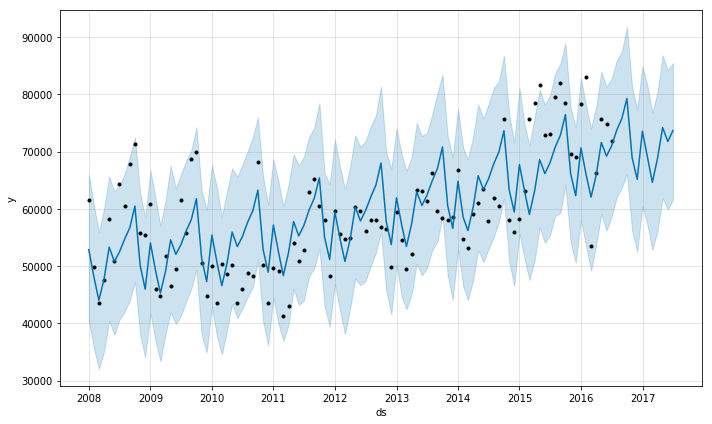

In [14]:
pierZim.plot(forecastZim)

In [ ]:
# Plot above shows a steady growth in the number of TEUS

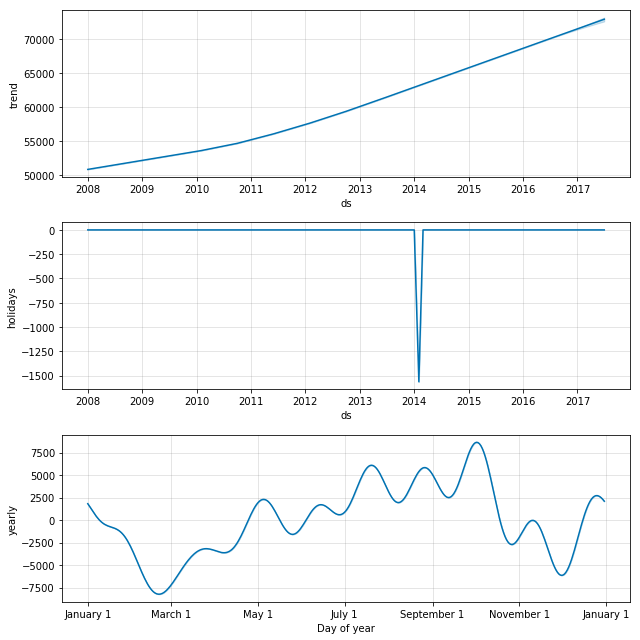

In [15]:
pierZim.plot_components(forecastZim)

The plots above show the trend and seasonalities, as seen there has been an increase in teus of about 20,000 between 2008 and 2017. 
The yearly seasonality shows a heavy drop between February and March, this is because of the chinese new year. September to October has the highest amount of TEUS due to preparation for christmas holidays 

In [16]:
# Selecting range for testing data
tester1 = dataFull[(dataFull['VMONTH']>='2016-07-31')]

In [17]:
tester1.head(3)

,VDATE,VMONTH,VQUARTER,VYEAR,SHIPNAME,VESSEL,CONQTY,TEUS
242266,2016-08-01 00:00:00,2016-08-01,2016 Q3,2016,CMA-CGM,CMA CGM RHONE,732,680.31
242267,2016-08-01 00:00:00,2016-08-01,2016 Q3,2016,CMA-CGM,COSCO GLORY,12,2.04
242288,2016-08-01 00:00:00,2016-08-01,2016 Q3,2016,CMA-CGM,CMA CGM MELISANDE,1499,1350.57


In [19]:
finalTest1 = tester1[['VMONTH', 'TEUS']].groupby('VMONTH').agg(np.sum).reset_index().sort_values('VMONTH')

In [20]:
#finalTest['TEUS'] = finalTest['TEUS']
finalTest1

,VMONTH,TEUS
0,2016-08-01,70568.18
1,2016-09-01,76681.20
2,2016-10-01,79160.00
3,2016-11-01,66953.62
4,2016-12-01,66699.10
5,2017-01-01,71723.09
6,2017-02-01,77578.08
7,2017-03-01,64563.16
8,2017-04-01,73099.13
9,2017-05-01,85807.78


In [21]:
len(finalTest1.index)

12

In [22]:
tab = forecastZim.iloc[-12:,:].reset_index().loc[:,['ds','yhat']]
tab[['y']] = finalTest1.reset_index()[['TEUS']]

In [23]:
trl = forecastZim[(forecastZim['ds']>'2015-07-31')&(forecastZim['ds']<'2016-07-31')]
len(trl.index)
#forecastZim.tail(3)

12

In [24]:
#Okay

In [31]:
dataZim1.to_csv('Train.csv',index=False)

(0, 200000)

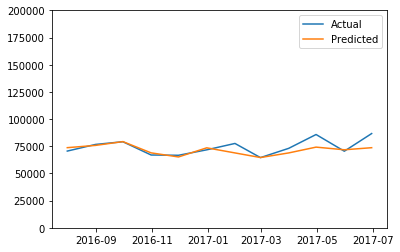

In [25]:
%matplotlib inline
plt.plot(tab.ds, tab.y,label='Actual')
plt.plot(tab.ds, tab.yhat,label='Predicted')
plt.legend(loc='best')
plt.ylim(0, 200000)
#plt.legend(handles=[line_up, line_down])

As seen above the predcited vs actual lines show there is a very little difference between the two

In [26]:
tab

,ds,yhat,y
0,2016-07-31,73704.692424,70568.18
1,2016-08-31,75788.651446,76681.20
2,2016-09-30,79279.806473,79160.00
3,2016-10-31,68920.228131,66953.62
4,2016-11-30,65162.388395,66699.10
5,2016-12-31,73559.841475,71723.09
6,2017-01-31,68871.562405,77578.08
7,2017-02-28,64630.829269,64563.16
8,2017-03-31,68875.336650,73099.13
9,2017-04-30,74204.772176,85807.78


In [27]:
MSE = np.sum(np.abs(tab.yhat-tab.y))
MSE//12  # Average Sum Absolute Error

4034.0

In [28]:
Sum_Square_Error = np.sum((tab.yhat-tab.y)**2)
np.sqrt(Sum_Square_Error/12)

5913.6564126888925

In [29]:
np.mean(np.abs((tab.y - tab.yhat) / tab.y)) * 100

5.088956886213886

The MSE, Sum Square Error and  Mean Absolute Percentage Error show that the forecasts made is very accurate.

In [4]:
len(dataM)

275734